<a href="https://colab.research.google.com/github/Daniilab/DSCI510_Final_Project/blob/main/Abbruzzese_Daniil_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import zipfile

# zip_file_path = "/content/data.zip?rlkey=i8x5qu0uzky3wjtrc8xy98w72"

# extract_to_path = '/content/data'

# # Unzipping the file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to_path)

# print("Unzipping completed.")

In [ ]:
from google.colab import drive
drive. mount ('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:

import zipfile

with zipfile.ZipFile('/content/drive/My Drive/Final_Project/data.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/drive/My Drive/Final_Project/Data')




In [11]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io

# Data Preprocessing

In [12]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# # Head directory containing all image subframes. Update with the relative path of your data directory
# data_head_dir = Path('/content/data/__MACOSX/data')
data_head_dir = Path('/content/drive/My Drive/Final_Project/Data/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [13]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# # Load the subframe names for the three data subsets
# train_ids = load_text_ids('/content/train_source_images.txt')
# validate_ids = load_text_ids('/content/val_source_images.txt')
# test_ids = load_text_ids('/content/test_source_images.txt')


# Load the subframe names for the three data subsets
train_ids = load_text_ids('/content/drive/My Drive/Final_Project/train_source_images.txt')
validate_ids = load_text_ids('/content/drive/My Drive/Final_Project/val_source_images.txt')
test_ids = load_text_ids('/content/drive/My Drive/Final_Project/test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

In [14]:
import random
import tensorflow as tf
from PIL import Image

def load_and_preprocess(img_loc, label):

    def _inner_function(img_loc, label):

        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')

        img = Image.open(img_loc_str).convert('RGB')


        return img, 1 if label_str=='frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

# (c) i - Image Augmentation

In [15]:
# one hot encoding

def one_hot_encode(image, label):
    return image, tf.one_hot(label, depth=2)

tf_dataset_train = tf_dataset_train.map(one_hot_encode)
tf_dataset_val = tf_dataset_val.map(one_hot_encode)
tf_dataset_test = tf_dataset_test.map(one_hot_encode)

In [7]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.1 MB/s eta 0:00:00


In [16]:
# retrying image augmentation to only augment 50 percent



import tensorflow as tf
import tensorflow_addons as tfa

def augment(image, label):
    if tf.random.uniform([]) <= 0.5:  # 50% probability
        image = tf.ensure_shape(image, [None, None, 3])

        # Randomly crop the image
        image = tf.image.random_crop(image, size=[250, 250, 3])

        # Randomly zoom the image
        image = tf.image.resize(image, [320, 320])
        image = tf.image.random_crop(image, size=[299, 299, 3])

        # Randomly rotate the image
        image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

        # Randomly flip the image
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)

        # Adjust contrast
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

        # Translate the image
        translations = tf.random.uniform(shape=[2], minval=-10, maxval=10, dtype=tf.float32)
        image = tfa.image.translate(image, translations)

    return image, label

# Rest of your data pipeline remains the same


# Unbatch the dataset
tf_dataset_train = tf_dataset_train.unbatch()

# Apply augmentation to the training dataset
tf_dataset_train = tf_dataset_train.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Rebatch the dataset
batch_size = 32  # or any batch size you prefer
tf_dataset_train = tf_dataset_train.batch(batch_size)


In [14]:
#augmenting all of the images -- old method

# import tensorflow_addons as tfa

# def augment(image, label):

#     image = tf.ensure_shape(image, [None, None, 3])

#     # Randomly crop the image
#     image = tf.image.random_crop(image, size=[250, 250, 3])

#     # Randomly zoom the image
#     image = tf.image.resize(image, [320, 320])
#     image = tf.image.random_crop(image, size=[299, 299, 3])

#     # Randomly rotate the image
#     image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

#     # Randomly flip the image
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)

#     # Adjust contrast
#     image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

#     # Translate the image
#     translations = tf.random.uniform(shape=[2], minval=-10, maxval=10, dtype=tf.float32)
#     image = tfa.image.translate(image, translations)

#     return image, label


# # Unbatch the dataset
# tf_dataset_train = tf_dataset_train.unbatch()

# # Apply augmentation to the training dataset
# tf_dataset_train = tf_dataset_train.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# # Rebatch the dataset
# batch_size = 32  # or any batch size you prefer
# tf_dataset_train = tf_dataset_train.batch(batch_size)


In [17]:
for images, labels in tf_dataset_train.take(1):
    print("Shape of images:", images.shape)
    print("Shape of labels:", labels.shape)


Shape of images: (32, 299, 299, 3)
Shape of labels: (32, 2)


### fixing shape

In [18]:

def _fixup_shape(images, labels):
    images.set_shape([None, 299, 299, 3])
    labels.set_shape([None, 2])
    return images, labels

tf_dataset_train = tf_dataset_train.map(_fixup_shape)
tf_dataset_val = tf_dataset_val.map(_fixup_shape)
tf_dataset_test = tf_dataset_test.map(_fixup_shape)

# (c) ii - CNN + MLP Training


Epoch 1/20
60/60 [==============================] - 27s 397ms/step - loss: 12.5134 - accuracy: 0.7791 - val_loss: 105.9410 - val_accuracy: 0.6795
Epoch 2/20
60/60 [==============================] - 28s 452ms/step - loss: 1.1255 - accuracy: 0.8804 - val_loss: 4.6882 - val_accuracy: 0.3616
Epoch 3/20
60/60 [==============================] - 24s 402ms/step - loss: 0.8810 - accuracy: 0.8977 - val_loss: 2.4768 - val_accuracy: 0.4192
Epoch 4/20
60/60 [==============================] - 24s 389ms/step - loss: 0.7832 - accuracy: 0.9029 - val_loss: 1.4502 - val_accuracy: 0.3863
Epoch 5/20
60/60 [==============================] - 28s 462ms/step - loss: 0.7436 - accuracy: 0.8987 - val_loss: 2.1159 - val_accuracy: 0.3945
Epoch 6/20
60/60 [==============================] - 23s 386ms/step - loss: 0.6707 - accuracy: 0.8883 - val_loss: 0.9554 - val_accuracy: 0.8712
Epoch 7/20
60/60 [==============================] - 24s 398ms/step - loss: 0.6548 - accuracy: 0.8804 - val_loss: 1.1759 - val_accuracy: 0.6

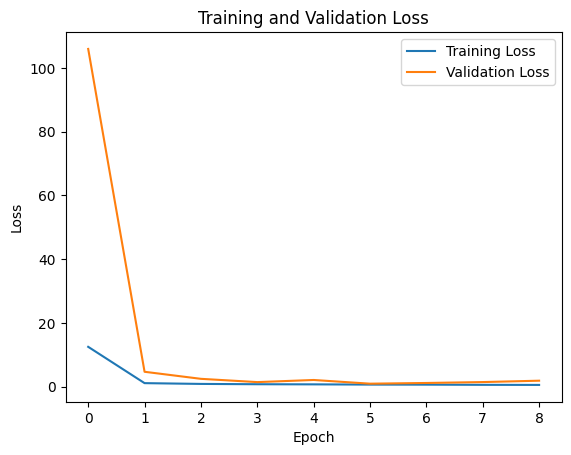

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy


# Define your CNN model
model = Sequential()

# First convolution layer
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(299, 299, 3), padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolution layer
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolution layer
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the output for the dense layer
model.add(Flatten())

# Dense layer
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))

# Output layer with softmax activation
model.add(Dense(2, activation='softmax'))  # Assuming binary classification ('frost' and 'background')

# Compile the model
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the model
history = model.fit(tf_dataset_train, validation_data=tf_dataset_val, epochs=20, callbacks=[early_stopping])


# Plotting training and validation errors
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# this took 30 minutes to run 442/442

# c (iii) - Report Precision, Recall, F1 Score

In [20]:
import numpy as np
import tensorflow as tf

# Initialize arrays for true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset
for images, labels in tf_dataset_test:
    # Predict
    predicted_probs = model.predict(images, verbose = 0)
    # Convert probabilities to class indices
    preds = np.argmax(predicted_probs, axis=1)

    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    predicted_labels.extend(preds)

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate metrics
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.675776397515528
Recall: 0.9477351916376306
F1 Score: 0.7889775199419871


# (d) i, ii, iii

Note: I already augmented images in (c)

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy  # Updated loss function
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import BatchNormalization, Dropout, Activation

# Adjusted function to add the last layer with ReLU, BatchNormalization, and Dropout
def add_last_layer(base_model, num_classes=2):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024)(x)  # No activation here, ReLU will be applied after BatchNormalization
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)  # Use softmax as per the instructions
    return Model(inputs=base_model.input, outputs=predictions)



# Load and freeze pre-trained models
def load_and_freeze_model(model_class, input_shape=(299, 299, 3)):
    model = model_class(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model.layers:
        layer.trainable = False
    return model

base_model_EfficientNetB0 = load_and_freeze_model(tf.keras.applications.EfficientNetB0)
model_EfficientNetB0 = add_last_layer(base_model_EfficientNetB0, num_classes=2)

base_model_ResNet50 = load_and_freeze_model(tf.keras.applications.ResNet50)
model_ResNet50 = add_last_layer(base_model_ResNet50, num_classes=2)

base_model_VGG16 = load_and_freeze_model(tf.keras.applications.VGG16)
model_VGG16 = add_last_layer(base_model_VGG16, num_classes=2)

# Compile the models
models = [model_EfficientNetB0, model_ResNet50, model_VGG16]
for model in models:
    # model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping and plot_history only once
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

58889256/58889256 [==============================] - 0s 0us/step


# (d) iv

Epoch 1/20
60/60 [==============================] - 36s 427ms/step - loss: 0.1009 - accuracy: 0.9681 - val_loss: 1.4772 - val_accuracy: 0.5452
Epoch 2/20
60/60 [==============================] - 23s 387ms/step - loss: 0.0418 - accuracy: 0.9864 - val_loss: 1.6163 - val_accuracy: 0.4356
Epoch 3/20
60/60 [==============================] - 25s 411ms/step - loss: 0.0275 - accuracy: 0.9906 - val_loss: 1.5097 - val_accuracy: 0.5534
Epoch 4/20
60/60 [==============================] - 23s 375ms/step - loss: 0.0126 - accuracy: 0.9974 - val_loss: 1.8210 - val_accuracy: 0.5151


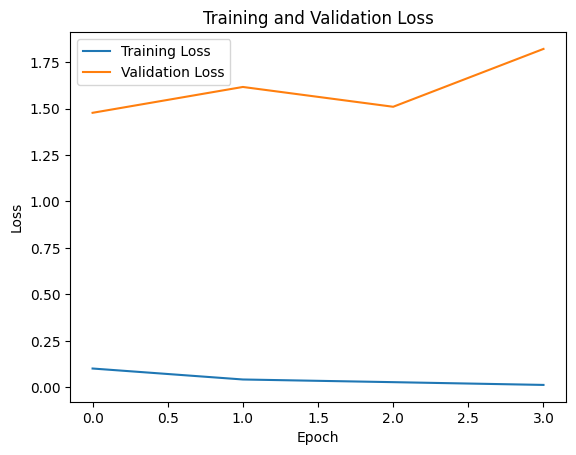

60/60 [==============================] - 17s 276ms/step - loss: 0.0171 - accuracy: 0.9974
Test Accuracy: 0.997389018535614, Test Loss: 0.017089687287807465


In [23]:
#for EfficientNetB0


history = model_EfficientNetB0.fit(tf_dataset_train, validation_data=tf_dataset_val, epochs=20, batch_size=8, callbacks=[early_stopping])

import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_history(history)  # Do this for each model


# test accuracy
test_loss, test_accuracy = model_EfficientNetB0.evaluate(tf_dataset_test)
print(f"Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")


Epoch 1/20
60/60 [==============================] - 45s 627ms/step - loss: 0.1274 - accuracy: 0.9619 - val_loss: 5.6835 - val_accuracy: 0.3973
Epoch 2/20
60/60 [==============================] - 29s 486ms/step - loss: 0.0232 - accuracy: 0.9916 - val_loss: 6.3371 - val_accuracy: 0.3781
Epoch 3/20
60/60 [==============================] - 28s 465ms/step - loss: 0.0164 - accuracy: 0.9953 - val_loss: 4.4667 - val_accuracy: 0.3370
Epoch 4/20
60/60 [==============================] - 27s 440ms/step - loss: 0.0136 - accuracy: 0.9963 - val_loss: 5.8565 - val_accuracy: 0.3507
Epoch 5/20
60/60 [==============================] - 28s 459ms/step - loss: 0.0064 - accuracy: 0.9974 - val_loss: 5.8685 - val_accuracy: 0.4274
Epoch 6/20
60/60 [==============================] - 30s 501ms/step - loss: 0.0076 - accuracy: 0.9979 - val_loss: 3.4961 - val_accuracy: 0.4438
Epoch 7/20
60/60 [==============================] - 29s 482ms/step - loss: 0.0055 - accuracy: 0.9990 - val_loss: 4.7700 - val_accuracy: 0.3726

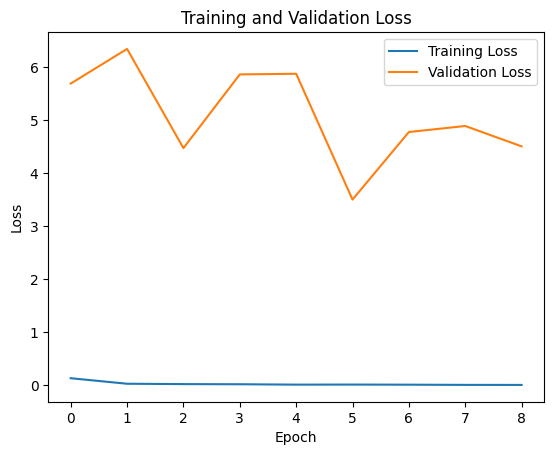

60/60 [==============================] - 22s 362ms/step - loss: 1.2606e-04 - accuracy: 1.0000
Test Accuracy: 1.0, Test Loss: 0.0001260594290215522


In [24]:
#for ResNet50


history = model_ResNet50.fit(tf_dataset_train, validation_data=tf_dataset_val, epochs=20, batch_size=8, callbacks=[early_stopping])

import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_history(history)  # Do this for each model


# test accuracy
test_loss, test_accuracy = model_ResNet50.evaluate(tf_dataset_test)
print(f"Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")

Epoch 1/20
60/60 [==============================] - 50s 716ms/step - loss: 0.1438 - accuracy: 0.9473 - val_loss: 3.0777 - val_accuracy: 0.5863
Epoch 2/20
60/60 [==============================] - 37s 610ms/step - loss: 0.0450 - accuracy: 0.9864 - val_loss: 2.5763 - val_accuracy: 0.5753
Epoch 3/20
60/60 [==============================] - 34s 568ms/step - loss: 0.0383 - accuracy: 0.9859 - val_loss: 1.9623 - val_accuracy: 0.5945
Epoch 4/20
60/60 [==============================] - 35s 571ms/step - loss: 0.0180 - accuracy: 0.9953 - val_loss: 1.9415 - val_accuracy: 0.6438
Epoch 5/20
60/60 [==============================] - 41s 674ms/step - loss: 0.0290 - accuracy: 0.9906 - val_loss: 2.3199 - val_accuracy: 0.6110
Epoch 6/20
60/60 [==============================] - 35s 565ms/step - loss: 0.0271 - accuracy: 0.9906 - val_loss: 2.2837 - val_accuracy: 0.6110
Epoch 7/20
60/60 [==============================] - 35s 577ms/step - loss: 0.0329 - accuracy: 0.9901 - val_loss: 1.5361 - val_accuracy: 0.6411

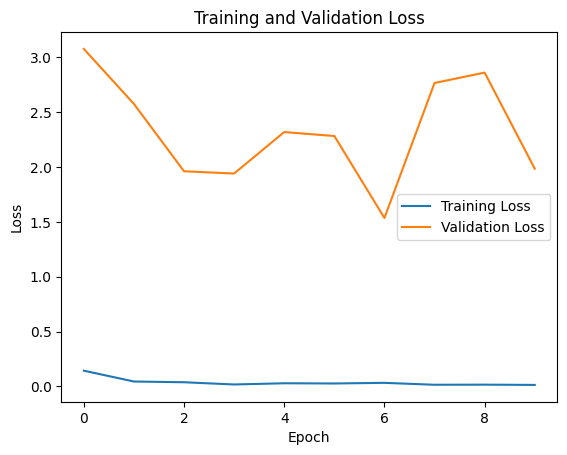

12/12 [==============================] - 5s 369ms/step - loss: 1.5361 - accuracy: 0.6411
Test Accuracy: 0.9984334111213684, Test Loss: 0.003967181779444218
val Accuracy: 0.6410958766937256, val Loss: 1.536091685295105


In [25]:
#for VGG16

history = model_VGG16.fit(tf_dataset_train, validation_data=tf_dataset_val, epochs=20, batch_size=8, callbacks=[early_stopping])

import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_history(history)  # Do this for each model


# test accuracy
test_loss, test_accuracy = model_VGG16.evaluate(tf_dataset_test)

val_loss, val_accuracy = model_VGG16.evaluate(tf_dataset_val)

print(f"Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")

print(f"val Accuracy: {val_accuracy}, val Loss: {val_loss}")

# (d) v

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np


from tensorflow.keras.callbacks import ModelCheckpoint



# Define your models and their names
models = [model_EfficientNetB0, model_ResNet50, model_VGG16]
model_names = ["EfficientNetB0", "ResNet50", "VGG16"]

for model, name in zip(models, model_names):
    true_labels = []
    predicted_labels = []

    # Iterate over the test dataset
    for images, labels in tf_dataset_test:
        # Predict
        predicted_probs = model.predict(images, verbose=0)
        # Convert probabilities to class indices
        preds = np.argmax(predicted_probs, axis=1)

        true_labels.extend(np.argmax(labels.numpy(), axis=1))
        predicted_labels.extend(preds)

    # Convert lists to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Calculate metrics
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    # Print metrics with model name
    print(f'Metrics for {name}:')
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)


Metrics for EfficientNetB0:
Precision: 0.9971370645776276
Recall: 0.9966410474267735
F1 Score: 0.9968886082769195
Metrics for ResNet50:
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Metrics for VGG16:
Precision: 0.9988839285714286
Recall: 0.9973867595818815
F1 Score: 0.9981312971140006


# (d) vi

CNN + MLP Results: Precision: 0.675776397515528
Recall: 0.9477351916376306
F1 Score: 0.7889775199419871

The results from transfer learning show that the transfer learning models all performed better than the CNN + MLP model. This is not suprising, as the transfer learning models were trained on a much larger data base and have a much more complex architecture than the CNN + MLP Model. Of the transfer learning models, ResNet50 performed best.